# __Tarea 2:__ Aprendizaje supervisado

1. Nombre: Rafael
1. Apellido: Contreras
1. Correo: rcontreraspimentel@gmail.com
1. Cedula: 30391915
--------

Algunas variables que podemos cambiar y que afectaran a todo el proyecto. SEED se refiere a la semilla usada para las funciones que generan numeros random. MAX_JOBS se refiere al numero de cores maximo permitido en algunos algoritmos.

Asimismo tenemos MAX_DATA_SIZE que configura con cuanta data se entrenaran los modelos a usar. Tiene que ser un valor entre 1 y 100, esto corresponde a que porcentaje de la data de mnist se usara para entrenar. Esta variable existe con el proposito de acelerar el desarrollo, ya que el entrenamiento con mnist tarda bastante.

In [1]:
SEED=30391915
MAX_JOBS=8 # configure to speed up training. Max number of cores used when -1
MAX_DATA_SIZE=30

## Parte 1

### Number recognition model

#### Utils and data visualization

En esta seccion definiremos algunas funciones que haran facil obtener la data.
Primero obtenemos las imagenes de mnist y luego las transformamos en vectores (concatenando cada fila de pixeles). Esta transformacion es necesaria para poder usar las imagenes en los modelos.

Definimos una funcion "obtain_data" para obtener una porcion del dataset. Esto es necesario solo para el modelo de logistic regression ya que el mismo tarda demasisado con el dataset completo.

In [13]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import joblib

def get_mnist_data():
    return mnist.load_data()

# convierte una matriz 28*28 en un vector
def vectorize(original):
    return original.reshape(original.shape[0], 28 * 28)

# obtenemos la data una sola vez ya vectorizada, no es
(x_train_o, y_train_o), (x_test_o, y_test_o) = get_mnist_data()
(x_train_o, y_train_o), (x_test_o, y_test_o) = (vectorize(x_train_o), y_train_o), (vectorize(x_test_o), x_test_o)

# esta funcion retorna solo una porcion del dataset. Default a 20% para hacer mas rapido el analisis de cual modelo es el mejor
def obtain_data(amount = MAX_DATA_SIZE):
    train_size,test_size = int(len(x_train_o) * amount / 100), int(len(x_test_o) * amount / 100)
    x_train, y_train = x_train_o[:train_size], y_train_o[:train_size]
    x_test, y_test = x_test_o[:test_size], y_test_o[:test_size]

    return (x_train, y_train), (x_test, y_test)


In [14]:
(x_train, y_train), (x_test, y_test) = obtain_data()

Ahora veremos la distribucion de elementos a clasificar del dataset. Hacemos esto para verificar que no exista una cantidad mucho mayor de ciertos elementos comparados con otros. Como vemos en la grafica resultado, no hay diferencias muy significativas en la cantidad de cada tipo de elemento.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)
classes = np.arange(10)  # los digitos de 0 a 9

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(classes - 0.2, train_counts, width=0.4, label="Train Data", color="blue", alpha=0.7)
ax.bar(classes + 0.2, test_counts, width=0.4, label="Test Data", color="orange", alpha=0.7)

ax.set_xticks(classes)
ax.set_xlabel("Digit Class")
ax.set_ylabel("Count")
ax.set_title("Distribution of Digits in Train and Test Data")
ax.legend()
plt.show()


#### Logistic regression

Ahora evaluaremos el performance de la regresion logistica. Para este algoritmo usaremos solo 30% de los datos para la evaluacion, dado que tarda mucho. Comenzaremos graficando el impacto de cambiar C en el performance del modelo. 

Esto solo se realizara para este modelo a manera informativa, luego solo se usara "GridSearchCV" para encontrar los parametros optimos.

In [10]:
(x_train, y_train), (x_test, y_test) = obtain_data()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

C_values = np.logspace(-10, 2, 10)
accuracies = []

# Esto toma un rato, ya que entrenamos y evaluamos el modelo multiples veces
# entrenar/evaluar al modelo para cada C
for C in C_values:
    model = LogisticRegression(solver='lbfgs', max_iter=1500, random_state=SEED, tol=1e-4, C=C, n_jobs=MAX_JOBS)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.xscale('log')  # mejora la visualizacion
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Impact of C on Logistic Regression Performance")
plt.grid(True)
plt.show()

Ahora evaluaremos diferentes valores para la tolerancia. Le daremos un valor de 5000 a la maxima cantidad de iteraciones para poder llegar a converger segun el valor de la tolerancia.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# probamos distintos valores para la tolerancia
tol_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
accuracies = []

for tol in tol_values:
    model = LogisticRegression(n_jobs=MAX_JOBS, solver='lbfgs', max_iter=1500, random_state=SEED, tol=tol, C=0.001)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(tol_values, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log') 
plt.xlabel("Tolerance (tol)")
plt.ylabel("Accuracy")
plt.title("Effect of Tolerance on Model Accuracy")
plt.grid(True)
plt.show()


In [21]:
(x_train, y_train), (x_test, y_test) = obtain_data()

In [ ]:
from sklearn.linear_model import LogisticRegression

# aqui entrenamos y guardamos el modelo final en esta variable que se usara para comparar luego
numbers_logistic_regression = LogisticRegression(n_jobs=-1, solver='lbfgs',max_iter=1500, random_state=SEED, tol=1e-5, C=1e-6)
numbers_logistic_regression.fit(x_train, y_train)

#### K-neighbours

Ahora evaluaremos el modelo de K-neighbours. Para encontrar los parametros obtimos usaremos GridSearchCV

In [23]:
(x_train, y_train), (x_test, y_test) = obtain_data()

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# parametros a probar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("best params:", grid_search.best_params_)
print("best accuracy:", grid_search.best_score_)

best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
best accuracy: 0.9601666666666666


In [25]:
# guardamos el modelo entrenado y continuamos
numbers_k_model = KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance', n_jobs=MAX_JOBS)
numbers_k_model.fit(x_train, y_train)

y_pred = numbers_k_model.predict(x_test)

#### SVM

Ahora evaluaremos SVM

In [23]:
(x_train, y_train), (x_test, y_test) = obtain_data(30) # con mas de un 30% de la data toma demasiado tiempo para entrenar

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],  
    'degree': [2, 3, 4]
}

svm = SVC(random_state=SEED)

grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', verbose=1, n_jobs=MAX_JOBS)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.9748750000000002


In [25]:
numbers_svm = SVC(**grid_search.best_params_)
numbers_svm.fit(x_train, y_train)

SVC(C=10, degree=2)

#### Comparacion de modelos

Mostraremos la diferencia en efectividad de todos los modelos usados usando distintas metricas. 

In [54]:
(x_train, y_train), (x_test, y_test) = obtain_data()

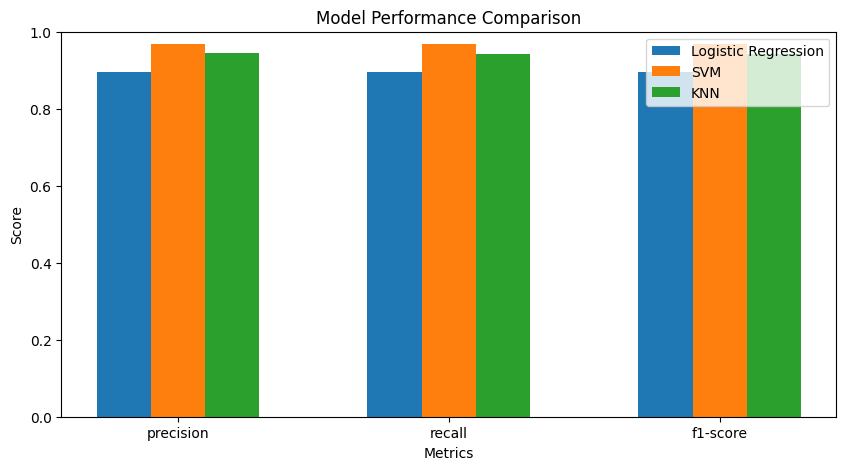

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# obtiene un reporte de la efectividad de la prediccion
def get_classification_metrics(y_test, y_pred):
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1-score": f1_score(y_test, y_pred, average="macro"),
    }

# los modelos a comparar
models = {
    "Logistic Regression": numbers_logistic_regression,
    "SVM": numbers_svm,
    "KNN": numbers_k_model
}

# las metricas a evaluar
metrics = ["precision", "recall", "f1-score", "accuracy"]
data = {metric: [] for metric in metrics}

for model_name, model in models.items():
    y_pred = model.predict(x_test)
    report = get_classification_metrics(y_test, y_pred)
    for metric in metrics:
        data[metric].append(report[metric] if metric != "accuracy" else report["accuracy"])

# convertimos la data de las metricas a numpy para graficarla
values = np.array([data[metric] for metric in metrics])
model_names = list(models.keys())

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(metrics))
width = 0.2  # Width of bars

for i, model_name in enumerate(model_names):
    ax.bar(x + i * width, values[:, i], width, label=model_name)

ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

plt.show()


Dado que el modelo con mejor performance es el SVM. Usaremos este para la evaluacion de numeros

In [26]:
import joblib

joblib.dump(numbers_svm, "numbers_model.joblib")

['numbers_model.joblib']

### Symbol recognition

#### Data

Aqui generamos nuestra propia data para los simbolos que queremos reconocer con nuestros modelos. Hemos generado suficientes imagenes para cada simbolo, estas seran cargadas con funciones que se encargan de mantener el grayscale y el 28x28 para facilitar su procesamiento.

A cada simbolo le asignamos un numero del 0 al 5.

In [7]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

# cargamos las imagenes. ya tienen el formato que queremos ya que vienen directamente del canvas
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))
            images.append(img)

    return np.array(images)

# esta funcion simplemente combina los diferentes tipos de imagenes y les aplica un label
def create_dataset(plus_imgs, minus_imgs, div_imgs, slash_imgs, times_imgs, x_imgs):
   x_data = np.vstack((plus_imgs, minus_imgs, div_imgs, slash_imgs, times_imgs, x_imgs))

   y_data = np.concatenate([
       np.zeros(len(plus_imgs)),  # 0 for plus
       np.ones(len(minus_imgs)),  # 1 for minus
       np.full(len(div_imgs), 2), # 2 for div
       np.full(len(slash_imgs), 3), # 3 for slash
       np.full(len(times_imgs), 4),  # 4 for asterisc
       np.full(len(x_imgs), 5)  # 5 for x
   ])
   return x_data, y_data


In [8]:
# cargamos las imagenes y creamos la data
plus_imgs = load_images("./data/Suma")
minus_imgs = load_images("./data/Resta")
div_imgs = load_images("./data/Division2")
slash_imgs = load_images("./data/Division1")
times_imgs = load_images("./data/Multiplicacion1")
x_imgs = load_images("./data/Multiplicacion2")

x_data, y_data = create_dataset(plus_imgs, minus_imgs, div_imgs, slash_imgs, times_imgs, x_imgs)

Dado que generamos nuestra propia data y no tenemos suficiente, hacemos "data augmentation". Esta tecnica se utiliza para generar artificialmente mas data para entrenar los modelos de machien learning.

En este caso usamos paquetes de keras, "ImageDataGenerator" que nos permite realizar esta tecnica sobre imagenes. Para generar imagenes artificiales hacemos leves cambios a las imagenes ya existentes. Entre los cambios configurados tenemos:

- **rotation_range=15:** Definimos un rango de rotación en grados que se aplicará aleatoriamente a las imágenes durante el preprocesamiento.
- **width_shift_range=0.02:** Especificamos un desplazamiento horizontal de la imagen como una fracción del ancho total.
- **height_shift_range=0.02:** Definimos un desplazamiento vertical de la imagen como una fracción de la altura total.
- **zoom_range=0.05:** Hacemos un zoom aleatorio que se aplicará a la imagen.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(x_data, y_data, factor=5):
    # Keras compatibility
    x_data = x_data.reshape((-1, 28, 28, 1))
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zoom_range=0.05
    )

    # generando nuevas imagenes
    augmented_images, augmented_labels = [], []
    for i in range(len(x_data)):
        img = x_data[i].reshape((1, 28, 28, 1))
        label = y_data[i]

        gen = datagen.flow(img, batch_size=1)
        for _ in range(factor):
            augmented_images.append(next(gen)[0].reshape(28, 28))
            augmented_labels.append(label)

    # convertimos a numpy
    x_augmented = np.array(augmented_images)
    y_augmented = np.array(augmented_labels)

    x_final = np.concatenate((x_data.squeeze(), x_augmented), axis=0)
    y_final = np.concatenate((y_data, y_augmented), axis=0)

    return x_final, y_final

x_data_aug, y_data_aug = augment_data(x_data,y_data)
# creamos 5 veces mas imagenes (parametro "factor")
print(len(x_data), len(x_data_aug))

756 4536


En esta seccion dividimos la data en entrenamiento y testing. Luego de generar mas data de forma artificial.
La proporcion es 70% de la data es usada para entrenamiento y el resto para testing.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data_aug, y_data_aug, 
    test_size=0.30, 
    random_state=42,
    stratify=y_data_aug
)

#### Logistic regression

Aplicamos regresion logistica. Usamos el "GridSearchCV" para buscar los mejores parametros posible para nuestro modelo. Se advierte que la habran varios warnings debido a que nunca se converge debido a que se requieren muchas iteraciones para esto.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
weights = dict(zip(unique_classes, len(y_train) / (len(unique_classes) * class_counts)))

param_grid = {
    "C": [0.01, 0.1, 1, 10],  
    "solver": ["lbfgs", "saga"], 
    "tol": [1e-4, 1e-3, 1e-2],
    "max_iter": [1500]
}

grid_search = GridSearchCV(
    LogisticRegression(class_weight=weights, random_state=42),
    param_grid,
    scoring="accuracy",
    n_jobs=MAX_JOBS
)

grid_search.fit(x_train_reshaped, y_train)
symbols_logistic_regression = grid_search.best_estimator_

y_pred = symbols_logistic_regression.predict(x_test_reshaped)
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'C': 0.01, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.01}
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       263
         1.0       0.78      0.82      0.80       221
         2.0       0.86      0.86      0.86       214
         3.0       0.89      0.82      0.86       223
         4.0       0.74      0.82      0.78       220
         5.0       0.85      0.82      0.83       220

    accuracy                           0.83      1361
   macro avg       0.83      0.83      0.83      1361
weighted avg       0.83      0.83      0.83      1361

#### K-neighbours

Aplicamos K-vecinos. Usamos el "GridSearchCV" para buscar los mejores parametros posible para nuestro modelo.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# transformamos la data
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Define hyperparameter grid for KNN
param_grid = {
    "n_neighbors": [3, 5, 7, 10],  # Number of neighbors
    "weights": ["uniform", "distance"],  # Weighting strategy
    "metric": ["euclidean", "manhattan", "minkowski"]  # Distance metrics
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring="accuracy",
    n_jobs=MAX_JOBS
)

grid_search.fit(x_train_reshaped, y_train)
symbols_k_model = grid_search.best_estimator_

y_pred = symbols_k_model.predict(x_test_reshaped)
print(f"Best Parameters: {grid_search.best_params_}")

#### SVM

Aplicamos SVM. Usamos el "GridSearchCV" para buscar los mejores parametros posible para nuestro modelo.

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

param_grid = {
    "C": [0.1, 1, 10, 100],  
    "kernel": ["linear", "rbf", "poly", "sigmoid"],  
    "gamma": ["scale", "auto"],  
}

grid_search = GridSearchCV(
    SVC(),
    param_grid,
    scoring="accuracy",
    n_jobs=MAX_JOBS
)

grid_search.fit(x_train_reshaped, y_train)
symbols_svm = grid_search.best_estimator_

y_pred = symbols_svm.predict(x_test_reshaped)
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


#### Comparacion de modelos

Al igual que antes, compararemos los modelos creados para usar el que mejor desempeno tenga.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# similar a las comparaciones que realizamos antes, pero con los modelos para simbolos

def get_classification_metrics(y_test, y_pred):
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1-score": f1_score(y_test, y_pred, average="macro"),
    }

models = {
    "Logistic Regression": symbols_logistic_regression,
    "SVM": symbols_svm,
    "KNN": symbols_k_model
}

metrics = ["precision", "recall", "f1-score", "accuracy"]
data = {metric: [] for metric in metrics}

for model_name, model in models.items():
    y_pred = model.predict(x_test)
    report = get_classification_metrics(y_test, y_pred)
    for metric in metrics:
        data[metric].append(report[metric] if metric != "accuracy" else report["accuracy"])

values = np.array([data[metric] for metric in metrics])
model_names = list(models.keys())

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(metrics))
width = 0.2  

for i, model_name in enumerate(model_names):
    ax.bar(x + i * width, values[:, i], width, label=model_name)

ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

plt.show()


In [12]:
import joblib

joblib.dump(symbols_svm, "symbols_model.joblib")

['symbols_model.joblib']

## Parte 2

### Opcion A

#### Cargar data

Cargamos la data para entrenar el modelo. La misma fue tomada de kaggle. Definimos una funcion para imprimir el desempeno del modelo

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

file_path = "./data/lol/data.csv"  
df = pd.read_csv(file_path)

#### Eliminacion de columnas

Eliminamos columnas que consideremos innecesarias. 
- gameID: es diferente para cada dataset, no contiene informacion relevante.
- blue/redEliteMonsters: Es un agregado de otras variables que definen los dragones/heraldos.
- blue/redCSPerMin: Ya tenemos la informacion en totalMinionsKilled.
- blue/redGoldPerMin: Ya tenemos la informacion en totalGold.

In [6]:
# El id del juego no nos interesa
df = df.drop(columns=["gameId"])
# Elite monsters ya es un agregado de dragones y heraldos
df = df.drop(columns=["blueEliteMonsters","redEliteMonsters"])
# Ya tenemos informacion de los minions asesinados en totalMinionsKilled
df = df.drop(columns=["blueCSPerMin","redCSPerMin"])
# Ya tenemos informacion del oro en totalGold
df = df.drop(columns=["blueGoldPerMin","redGoldPerMin"])
# Blue wins mejor guardarla en y_data
y_data = df["blueWins"]
df = df.drop(columns=["blueWins"])

#### Exploracion/visualizacion de datos

Ya que tenemos distintas variables numericas cuyos valores (dependiendo de la variable) tienen rangos distintos (ejemplo goldPerMin y CSPerMin), es necesario estandarizar la data. El proceso de estandarizacion evita que una variable sea mas dominante que otras cuando se trata de su impacto en el modelo. Si tenemos variables en el rango 1000-10000 y otras en el rango 1-100, las segundas pueden tener menor impacto en el modelo y al mismo tiempo ser mas significativas en la prediccion de la variable objetivo.

El proceso de visualizacion realizado es para darnos cuenta de estas diferencias de rangos. Asi mismo nos damos cuenta del tipo de distribucion que tienen las variables.

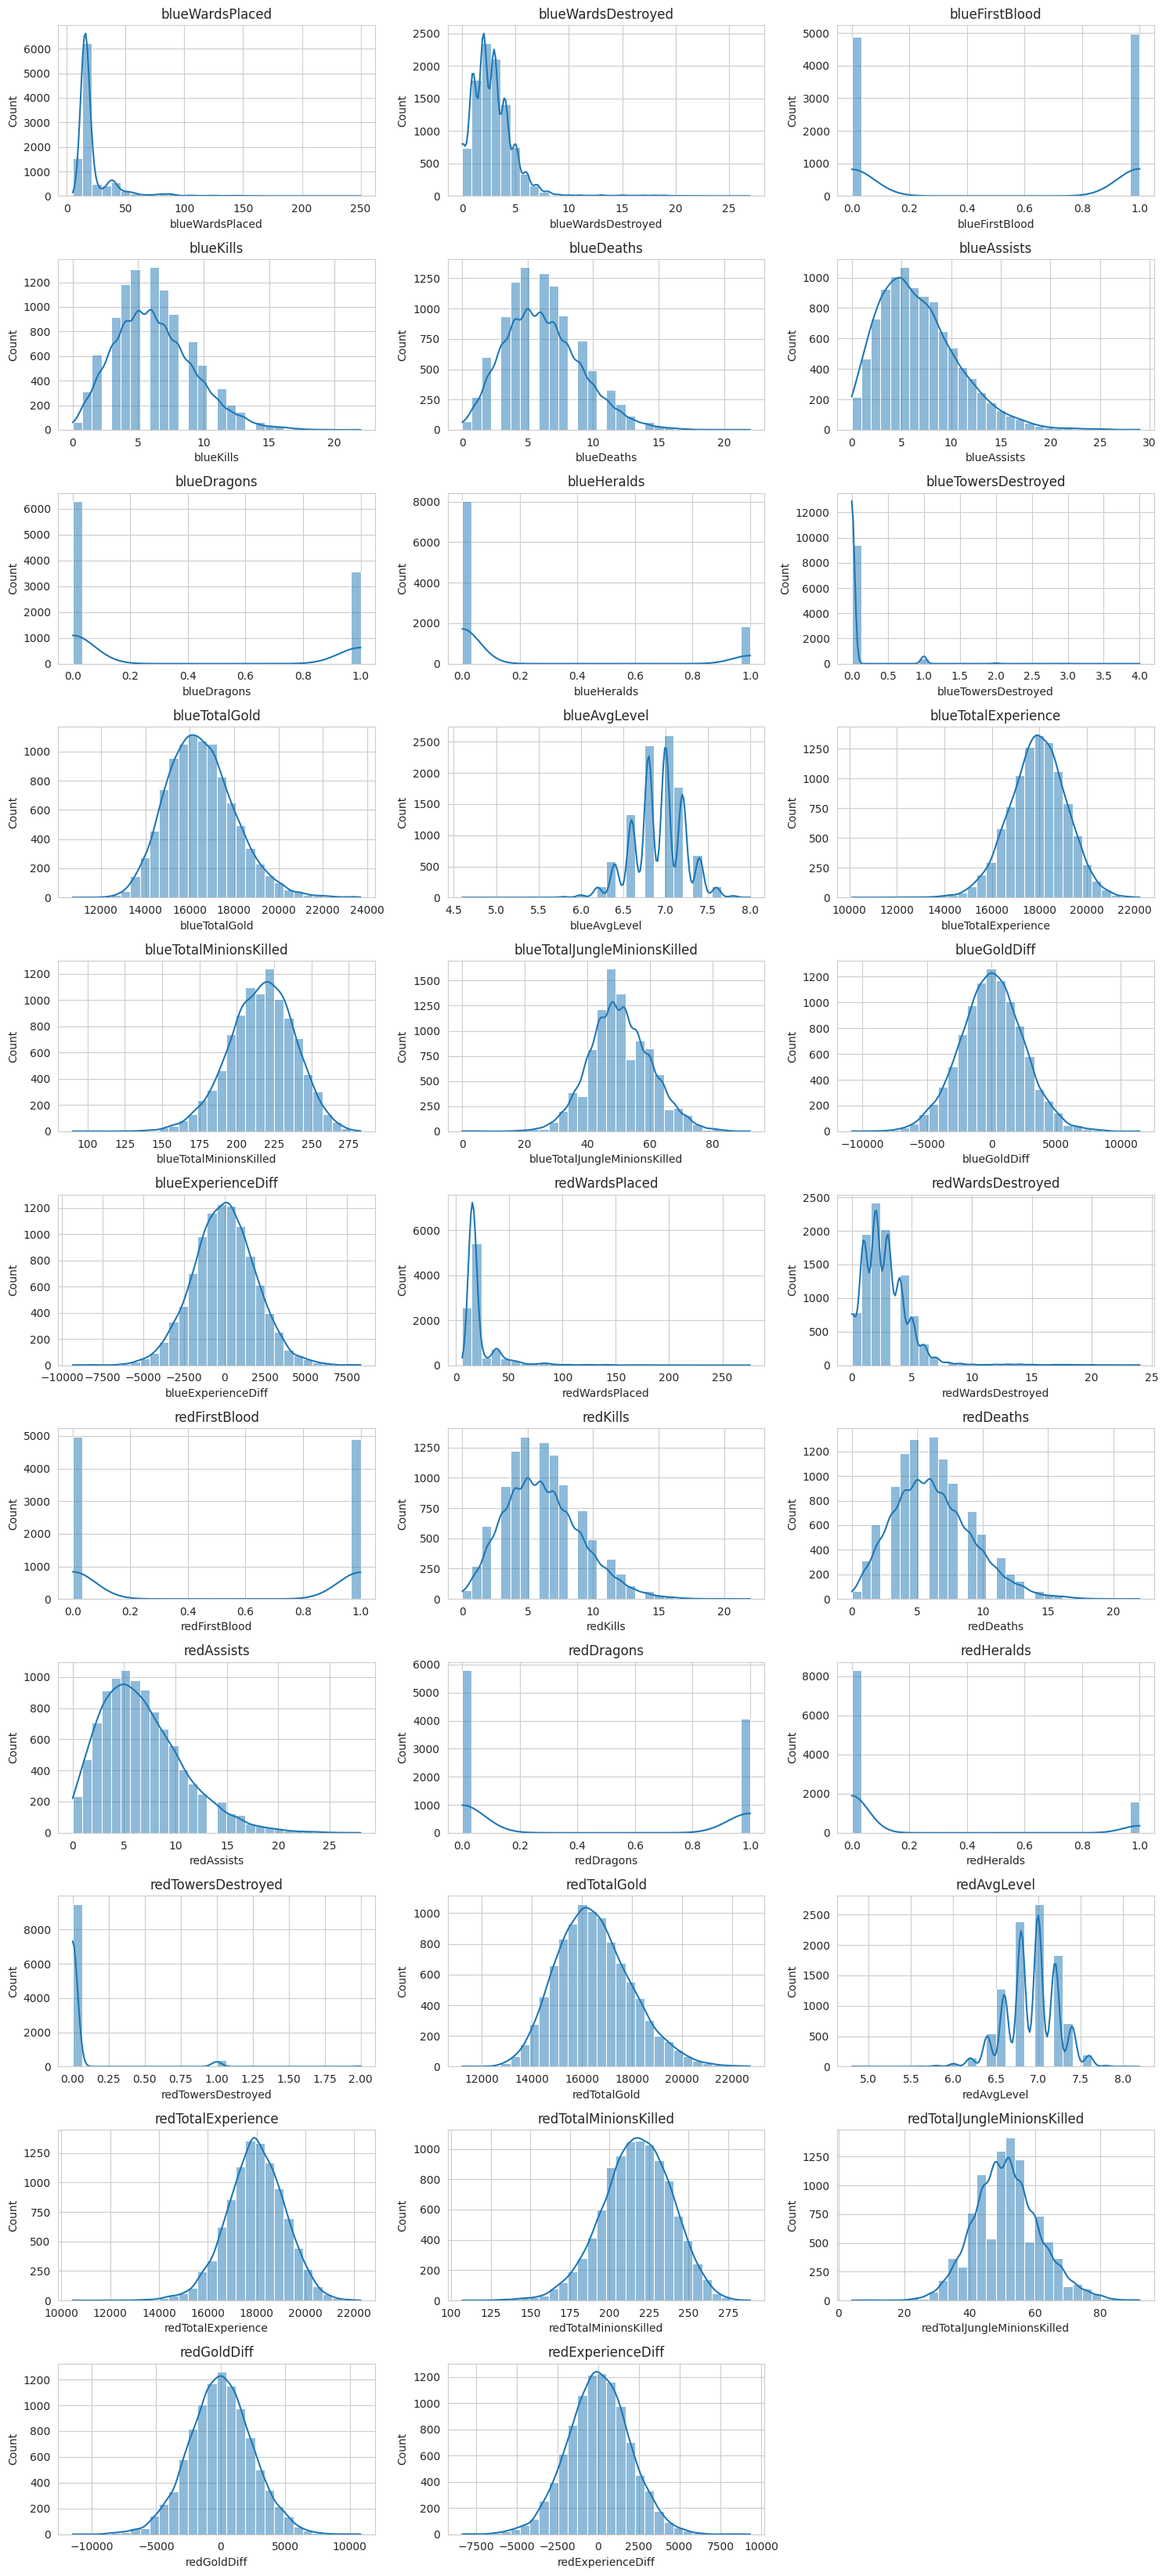

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# aqui buscamos visualizar la mayor cantidad de variables en el minimo espacio, ya que son muchas

sns.set_style("whitegrid")

# numero de columnas por fila
cols_per_row = 3  
num_features = len(df.columns)
rows = (num_features // cols_per_row) + (num_features % cols_per_row > 0)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 3))
axes = axes.flatten() 

for i, col in enumerate(df.select_dtypes(include=["number"]).columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Estandarizacion de los datos

Los resultados de la visualizacion nos dejaron con algunas variables que tomaremos como categoricas y otras cuyo valor es numerico. Ya que todas las variables numericas tienen una distribucion normal, usaremos el "StandardScaler".

In [8]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

prefix = ['FirstBlood', 'Dragons', 'Heralds', 'TowersDestroyed']
categorical = list(map(lambda x: ['blueWins'] if x == 'Wins' else ['blue' + x, 'red' + x],prefix))
categorical = [item for sublist in categorical for item in sublist]

numerical = df.columns.difference(categorical).tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical), 
        ('cat', 'passthrough', categorical)
    ]
)

#### Separacion de data

Separamos la data que tenemos en data de entrenamiento y de testing. La proporcion es 70/30.

In [9]:
from sklearn.model_selection import train_test_split

x_data = df.copy()
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, 
    test_size=0.30, 
    random_state=42
)

#### Creacion de modelo

Usamos el modelo de regresion logistica para resolver el problema. Usamos "GridSearchCV" para encontrar los parametros optimos para el problema.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['lbfgs', 'liblinear', 'saga'],  # Solver methods
    'classifier__max_iter': [500, 1000, 2000],  # Maximum iterations
}

model = Pipeline([
    ('preprocess', preprocessor),  
    ('classifier', LogisticRegression())  
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__solver': 'lbfgs'}
Best Accuracy: 0.7320318148951556


In [14]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)
classification_report(y_test, y_pred, output_dict=True)

Accuracy: 0.7274
Precision: 0.7275
Recall: 0.7274
F1 Score: 0.7274
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=1000, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=1000, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.01, classifier__max_iter=500, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=500, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.01, classifier__max_iter=2000, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__max_iter=500, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__max_iter=500, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__max_iter=500, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=1, c